# Carbon Dioxide Prediction (1974-2070)
### Written by Seongheon Park in 2022

#### Import necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Import CSV and set index as Year and Month

In [2]:
df = pd.read_csv("carbon deoxide (in ppm) cleared.csv", parse_dates=[["Year", "Month"]])

In [3]:
data = df.set_index("Year_Month")

#### Remove error values

In [4]:
cols = data.columns
for j in cols:
    for i in range(len(data)):
        if data[j][i] == -1 or data[j][i] == -9.99 or data[j][i] == -0.99:
            data[j][i] = data[j][i-1]

from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(data.drop("Monthly Average", axis=1), -1, 1).eig

/tmp/ipykernel_20537/2140088754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[j][i] = data[j][i-1]


array([0.35313811, 0.33087998, 0.26822614, 0.14359813, 0.0230061 ])

#### Seasonal Decompose

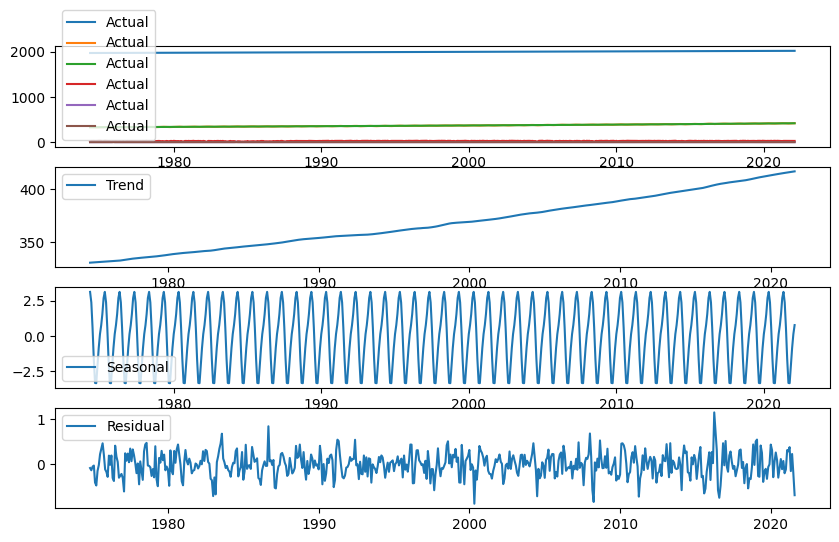

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decom=seasonal_decompose(data["Monthly Average"])
dftend=decom.trend
dfsea=decom.seasonal
dfres=decom.resid
plt.figure(figsize=(10,6))
plt.subplot (411)
plt.plot(data,label='Actual')
plt.legend()
plt.subplot (412)
plt.plot(dftend,label='Trend')
plt.legend()
plt.subplot (413)
plt.plot(dfsea,label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(dfres, label='Residual')
plt.legend()

#### Find SARIMAX variables using auto_arima

In [6]:
from pmdarima.arima import auto_arima

model = auto_arima(data["Monthly Average"], seasonal=True, m=12, information_criterion="aic")

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  574
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -164.636
Date:                            Sat, 17 Dec 2022   AIC                            339.271
Time:                                    05:54:02   BIC                            361.026
Sample:                                05-01-1974   HQIC                           347.757
                                     - 02-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1687      0.027      6.284      0.000       0.116       0.221
ma.L1         -0.5335      0.039    -13.794      0.000      -0.609      -0.458
ar.S.L12       0.9997      0.000   4247.777      0.000       0.999       1.000
ma.S.L12      -0.8755      0.025    -35.593      0.000      -0.924      -0.827
sigma2         0.0944      0.005     18.909      0.000       0.085       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 5.65
Prob(Q):                              0.81   Prob(JB):                         0.06
Heteroskedasticity (H):               1.39   Skew:                             0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prepare for prediction

In [10]:
size = int(len(data) * 0.7)

Xtrain, Xtest = data[0:size], data[size:]

#### Train SARIMAX model and do test

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(Xtrain["Monthly Average"], order=(2,2,1), seasonal_order=(1,0,1,12))
result = model.fit()

testprid = pd.DataFrame(result.predict(start=len(Xtrain), end=len(data)))
testprid.columns = ['Prediction']

data = pd.concat((data, testprid), axis=1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89389D-01    |proj g|=  7.10259D-01


 This problem is unconstrained.



At iterate    5    f=  3.09427D-01    |proj g|=  1.58521D-01

At iterate   10    f=  3.00235D-01    |proj g|=  5.39934D-02

At iterate   15    f=  2.99655D-01    |proj g|=  5.04582D-02

At iterate   20    f=  2.94950D-01    |proj g|=  4.61350D-02

At iterate   25    f=  2.93951D-01    |proj g|=  2.72151D-02

At iterate   30    f=  2.71175D-01    |proj g|=  1.37391D-01

At iterate   35    f=  2.52903D-01    |proj g|=  2.70191D-02

At iterate   40    f=  2.51820D-01    |proj g|=  2.31552D-02

At iterate   45    f=  2.51737D-01    |proj g|=  2.09126D-02

At iterate   50    f=  2.51709D-01    |proj g|=  5.09409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Note: I edited one of SARIMAX variable to predict more precisely, based on some tests I did before.

### Predict with SARIMAX

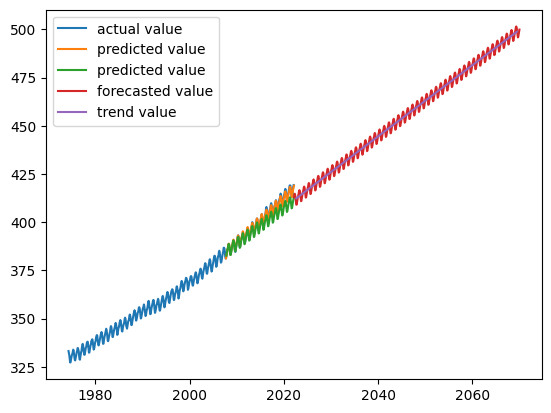

In [12]:
yhat = result.predict(start="2022-03-01", end="2070-01-01")

plt.plot(data.index, data["Monthly Average"], label="actual value")
plt.plot(data.index, data["Prediction"], label="predicted value")
plt.plot(pd.DataFrame(yhat), label="forecasted value")

yhat_trend = seasonal_decompose(yhat).trend

plt.plot(pd.DataFrame(yhat_trend), label="trend value")

plt.legend()